In [41]:
import numpy as np
from typing import List
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os 
import netCDF4 as nc
from sklearn.model_selection import train_test_split

Create a X Design matrix made in shape (400*600, 24)
when each row is a grid point and each feature is a model.

In [42]:
import numpy as np
from typing import List

def flatten_models_to_grid_matrix(interpolated_precip_list: List[np.ndarray]) -> np.ndarray:
    """
    Create a design matrix X where each row represents a grid point, and each column 
    (feature) represents the flattened precipitation data from a different model.

    Parameters:
    -----------
    interpolated_precip_list : List[np.ndarray]
        A list of 2D arrays (matrices) with dimensions (400, 600) representing 
        precipitation data from different models. Each matrix corresponds to a different 
        model.

    Returns:
    --------
    np.ndarray
        A 2D array (design matrix X) of shape (240000, num_models), where:
        - Each row corresponds to a specific grid point across all models.
        - Each column corresponds to the precipitation data for that grid point from 
          a particular model.

    Notes:
    ------
    - The output design matrix is of shape (240000, num_models), where:
        - 240,000 = 400 * 600 represents all grid points.
        - num_models is the number of models, i.e., the length of the input list.
    - Each row in the matrix corresponds to a unique grid point from the (400, 600) 
      grid, and each feature (column) corresponds to one of the models.
    """
    
    # Number of models and number of grid points
    num_models = len(interpolated_precip_list)
    num_grid_points = 400 * 600

    # Initialize an empty matrix to store the reshaped data
    X = np.zeros((num_grid_points, num_models))

    # Loop over each model's matrix and reshape it into a vector
    for i, precip_matrix in enumerate(interpolated_precip_list):
        # Reshape each (400, 600) matrix to (240000,) and assign it to the ith column
        X[:, i] = precip_matrix.reshape(-1)

    return X


In [43]:
data_relative_path = os.path.join('..', 'Data')
cmip_models_path_path = os.path.join(data_relative_path,'CMIP6','Precipitation')
interpulated_cmip_path = os.path.join(data_relative_path,'InterpulatedCMIP6_400X600')
CHIRPS_path = os.path.join(data_relative_path,'CHIRPS2')


In [44]:
def get_chirps_flat():
    chirps_dataset = nc.Dataset(f"{CHIRPS_path}/chirps_octobers_middle_east_1981_2010.nc") # CHIRPS_Monthly_precipitation
    chirps_precip_data = np.array(chirps_dataset.variables['precip'][:])
    chirps_2D = np.mean(chirps_precip_data,axis=0)
    flat_chirps_2D= chirps_2D.reshape(-1)
    return flat_chirps_2D

In [52]:
def get_precipitatioon_models():
    models : list[np.ndarray] = []
    for file in os.listdir(interpulated_cmip_path):
        model_path = os.path.join(interpulated_cmip_path,file)
        model_data = np.load(model_path)
        model_mean_data = np.mean(model_data, axis=0) 
        models.append(model_mean_data)
    return models


# Flatening the Data and Training the 

In [53]:
# get correlation and precipitation data in 24-sized list 
models_precipitation : list[np.ndarray] = get_precipitatioon_models()
# ################### ADD CORRELATIOB MATS HERE ###################
# after just uncomment all the commented line and you are good!
models_correlation : list[np.ndarray] = []

# Flattening the data 
X_precipitation : np.ndarray = flatten_models_to_grid_matrix(models_precipitation)
# X_correlation : np.ndarray = flatten_models_to_grid_matrix(models_correlation)


y_precipitation : np.ndarray = np.mean(X_precipitation, axis=1)
# y_correlation : np.ndarray = np.mean(X_correlation, axis=1)
y_chirps : np.ndarray = get_chirps_flat()

# Convert data to float64 to handle large values
X_precipitation = X_precipitation.astype(np.float64)
y_precipitation = y_precipitation.astype(np.float64)

y_chirps = y_chirps.astype(np.float64)



# Split The Data randomly 

In [46]:

# Precipitation data
x_precipitation_train, x_precipitation_test, y_precipitation_train, y_precipitation_test =  train_test_split( X_precipitation, y_precipitation, test_size=0.2, random_state=42)
ד
# Correlation data
# x_correlation_train, x_correlation_test, y_correlation_train, y_correlation_test = \
# train_test_split(
#     X_correlation, y_correlation, test_size=0.2, random_state=42)

# Chirps data
x_chirps_train, x_chirps_test, y_chirps_train, y_chirps_test = \
train_test_split(
    X_precipitation, y_chirps, test_size=0.2, random_state=42)  

# Trainig Linear Regression models 

In [47]:
# Initialize models for precipitation, chirps, and correlation
reg_model_precipitation = LinearRegression()
reg_model_chirps = LinearRegression()
# reg_model_correlation = LinearRegression()

# Train the models on the training data
reg_model_precipitation.fit(x_precipitation_train, y_precipitation_train)
reg_model_chirps.fit(x_chirps_train, y_chirps_train)
# reg_model_correlation.fit(x_correlation_train, y_correlation_train)

# Predict the target values on the testing data
y_precipitation_pred = reg_model_precipitation.predict(x_precipitation_test)
y_chirps_pred = reg_model_chirps.predict(x_chirps_test)
# y_correlation_pred = reg_model_correlation.predict(x_correlation_test)

# Evaluate the model performance for precipitation
mse_precipitation = mean_squared_error(y_precipitation_test, y_precipitation_pred)
r2_precipitation = r2_score(y_precipitation_test, y_precipitation_pred)

# Evaluate the model performance for chirps
mse_chirps = mean_squared_error(y_chirps_test, y_chirps_pred)
r2_chirps = r2_score(y_chirps_test, y_chirps_pred)

# Evaluate the model performance for correlation
# mse_correlation = mean_squared_error(y_correlation_test, y_correlation_pred)
# r2_correlation = r2_score(y_correlation_test, y_correlation_pred)

# Print the results
print(f"Precipitation Model - MSE: {mse_precipitation}, R2: {r2_precipitation}")
print(f"Chirps Model - MSE: {mse_chirps}, R2: {r2_chirps}")
# print(f"Correlation Model - MSE: {mse_correlation}, R2: {r2_correlation}")

Precipitation Model - MSE: 2.776962069084859e-40, R2: 1.0
Chirps Model - MSE: 5.80817179635622e+72, R2: 0.5912516350936388


# coefficient evaluetion

In [48]:
def plot_coefficients(coefficients: np.ndarray, model_names: List[str], title: str):
    """
    Plot the coefficients of the regression model.

    Parameters:
    -----------
    coefficients : np.ndarray
        The regression coefficients for each model.
        
    model_names : List[str]
        The names or labels of the models corresponding to the coefficients.

    title : str
        Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(model_names, coefficients, color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(title)
    plt.show()

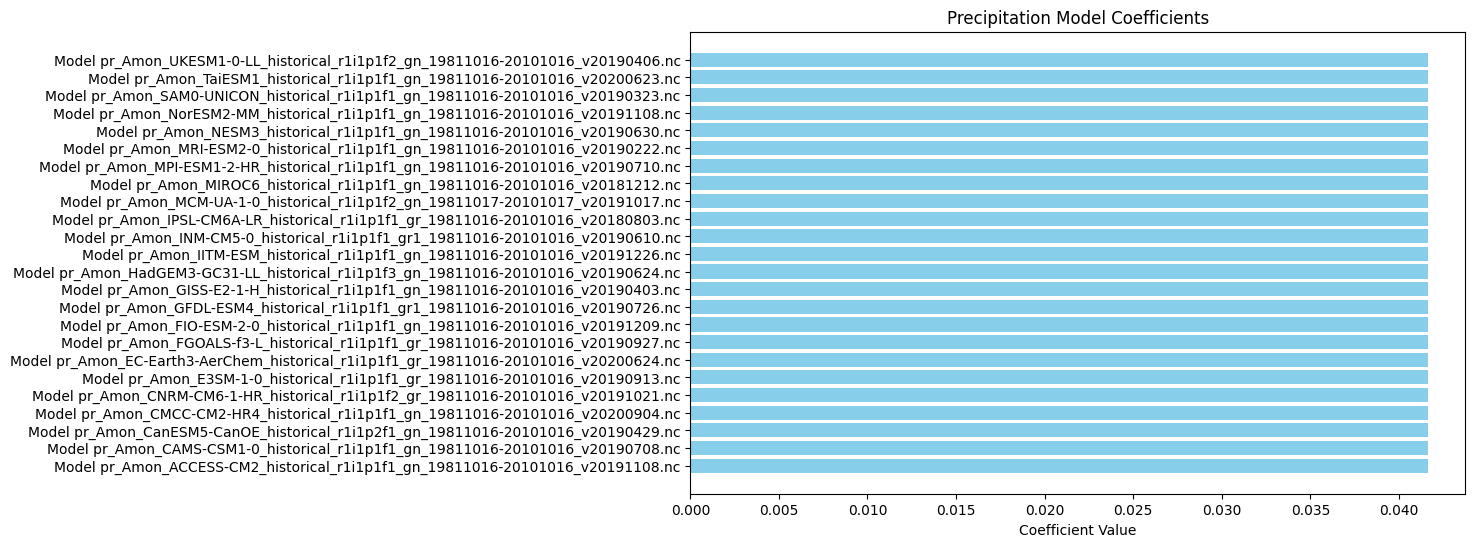

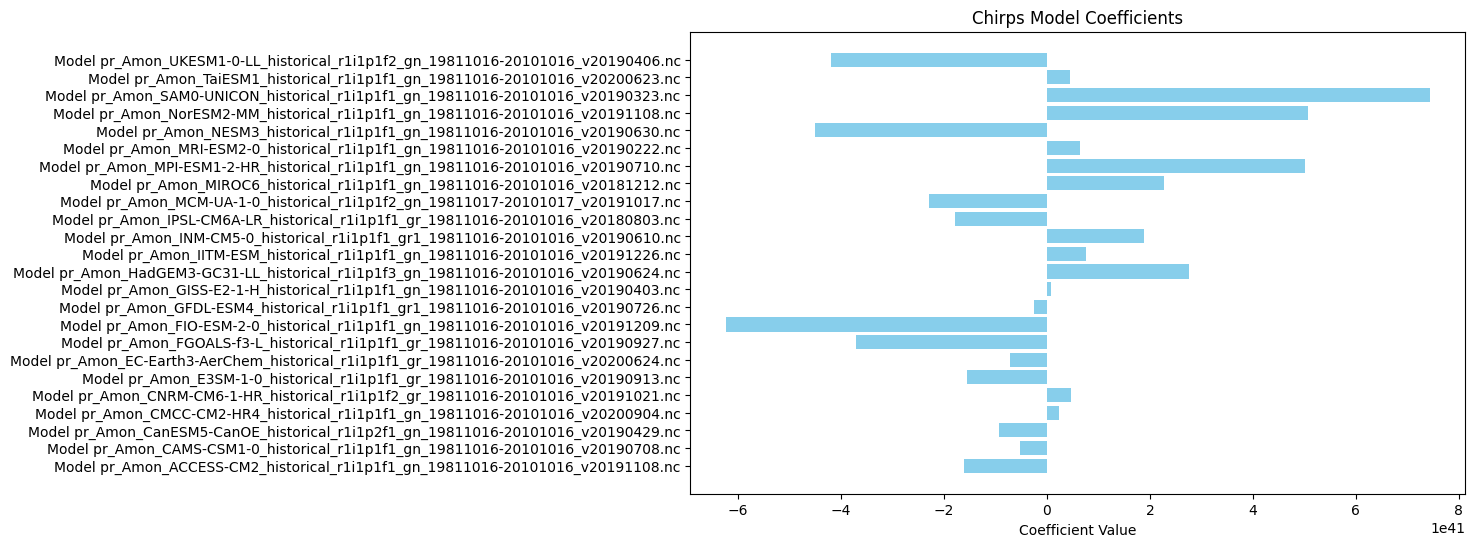

In [49]:
CMIP_PATH = os.path.join('..','Data','CMIP6','Precipitation')
model_names = [f'Model {model_name}' for model_name in os.listdir(CMIP_PATH)]  # Replace with actual model names if available
precipitation_coefficients = reg_model_precipitation.coef_
# correlation_coefficients = reg_model_precipitation.coef_
chirps_coefficients = reg_model_chirps.coef_


plot_coefficients(precipitation_coefficients, model_names, 'Precipitation Model Coefficients')
# plot_coefficients(correlation_coefficients, model_names, 'Correlation Model Coefficients')
plot_coefficients(chirps_coefficients, model_names, 'Chirps Model Coefficients')
